# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [39]:
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [41]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.291657
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** 

我们期望损失值接近于 -log(0.1) 是因为在没有经过训练的情况下，分类器的权重矩阵 W 是随机初始化的。在这种情况下，对于每个样本，分类器输出的每个类别的得分（经过 softmax 计算后）可能接近均匀分布。对于一个有 10 个类别的分类问题来说，均匀分布下每个类别的概率是 0.1。

在 softmax 损失函数中，对于每个样本的正确类别 y[i]，损失计算为 -log(softmax 输出的正确类别的概率)。如果这个概率接近 0.1，那么损失就会接近 -log(0.1)，即大约 2.302。

因此，在模型未经过训练或随机初始化时，分类器的输出接近于随机猜测，我们期望损失值接近 -log(0.1)。


In [42]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.526392 analytic: -0.526392, relative error: 3.126105e-08
numerical: 1.256876 analytic: 1.256876, relative error: 7.064840e-08
numerical: 3.243370 analytic: 3.243370, relative error: 4.222978e-09
numerical: -1.019065 analytic: -1.019066, relative error: 9.201099e-08
numerical: -0.183924 analytic: -0.183924, relative error: 4.183267e-07
numerical: -2.022027 analytic: -2.022027, relative error: 2.345820e-08
numerical: 2.878284 analytic: 2.878284, relative error: 1.936875e-08
numerical: 0.961133 analytic: 0.961133, relative error: 3.168448e-08
numerical: 1.656416 analytic: 1.656416, relative error: 1.607336e-09
numerical: -2.012042 analytic: -2.012042, relative error: 3.136901e-09
numerical: 1.083777 analytic: 1.083777, relative error: 2.171936e-08
numerical: -2.252823 analytic: -2.252823, relative error: 1.928202e-08
numerical: 0.073278 analytic: 0.073278, relative error: 6.433925e-07
numerical: -0.450575 analytic: -0.450575, relative error: 5.577694e-08
numerical: 0.977775 

In [43]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.291657e+00 computed in 0.041559s
vectorized loss: 2.291657e+00 computed in 0.003646s
Loss difference: 0.000000
Gradient difference: 0.000000


In [44]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
import itertools

# 使用 itertools.product 生成所有参数组合
param_combinations = list(itertools.product(learning_rates, regularization_strengths))
for combo in param_combinations:
    print(combo)

    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, learning_rate=combo[0], reg=combo[1],
                                num_iters=3000, verbose=True)     # iters = 1500
    # plt.plot(loss_hist)
    # plt.xlabel('Iteration number')
    # plt.ylabel('Loss value')
    # plt.show()
    y_train_pred = softmax.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred)
    print('training accuracy: %f' % (train_accuracy, ))
    y_val_pred = softmax.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    print('validation accuracy: %f' % (val_accuracy, ))
    
    results[combo] = (train_accuracy, val_accuracy)
    if best_val <= val_accuracy:
        best_val = val_accuracy
        best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

(1e-07, 25000.0)
iteration 0 / 3000: loss 787.618744
iteration 100 / 3000: loss 288.753721
iteration 200 / 3000: loss 106.990446
iteration 300 / 3000: loss 40.465950
iteration 400 / 3000: loss 16.196679
iteration 500 / 3000: loss 7.211054
iteration 600 / 3000: loss 3.974868
iteration 700 / 3000: loss 2.775428
iteration 800 / 3000: loss 2.246518
iteration 900 / 3000: loss 2.180532
iteration 1000 / 3000: loss 2.084695
iteration 1100 / 3000: loss 2.107943
iteration 1200 / 3000: loss 2.109356
iteration 1300 / 3000: loss 2.109050
iteration 1400 / 3000: loss 2.119651
iteration 1500 / 3000: loss 2.050630
iteration 1600 / 3000: loss 2.107799
iteration 1700 / 3000: loss 2.139021
iteration 1800 / 3000: loss 2.109481
iteration 1900 / 3000: loss 2.022870
iteration 2000 / 3000: loss 2.086182
iteration 2100 / 3000: loss 2.043675
iteration 2200 / 3000: loss 2.055345
iteration 2300 / 3000: loss 2.066827
iteration 2400 / 3000: loss 2.073786
iteration 2500 / 3000: loss 2.039541
iteration 2600 / 3000: lo

In [45]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.339000


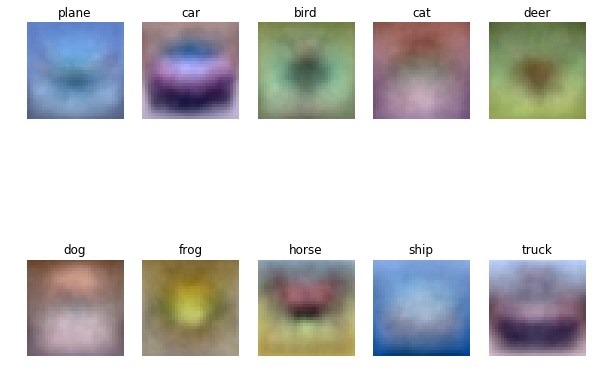

In [46]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])